In [1]:
%matplotlib inline

In [2]:
import torch 
import torchvision.transforms as transforms
from torchvision import datasets, models
import numpy as np
import torchvision.models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import time
import os


In [3]:

def load_split_train_val(datadir, valid_size = .25):

    normalize=transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])
    train_transforms = transforms.Compose([transforms.Resize(224),
                                        transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       #normalize
                                       ])
    val_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      #normalize
                                      ])
    train_data = torchvision.datasets.ImageFolder(datadir,
                    transform=train_transforms)
    val_data = torchvision.datasets.ImageFolder(datadir,
                    transform=val_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, val_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=1)
    valloader = torch.utils.data.DataLoader(val_data,
                   sampler=val_sampler, batch_size=1)
    return trainloader, valloader


In [4]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    #train_losses, test_losses = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            i = 0
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
                dataloader = trainloader
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valloader
            running_loss = 0.0
            running_corrects = 0.0

            # Iterate over data.
            for data in dataloader:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data).to(torch.float32)
                #print (str(i) + ":" + str(running_loss) + ":" + str(running_corrects))
                #i += 1
                
                #train_losses.append(running_loss/len(trainloader))
                #test_losses.append(test_loss/len(testloader)) 
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model#, train_losses, test_losses

In [5]:
data_dir = 'data/trainval/species/'
trainloader, valloader = load_split_train_val(data_dir, .25)


dataset_sizes = {
    "train": len(trainloader),
    "val": len(valloader)
}


# use gpu or not
use_gpu = torch.cuda.is_available()
#print (torch.cuda.is_available())
# get model and replace the original fc layer with your fc layer


# Best val Acc: 0.871186
model_ft = torchvision.models.resnet50(pretrained=True)
#model_ft = torchvision.models.densenet161(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

# define loss function
criterion = nn.CrossEntropyLoss()



# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.01)
model_ft = train_model(model=model_ft,
                           criterion=criterion,
                           optimizer=optimizer_ft,
                           scheduler=exp_lr_scheduler,
                           num_epochs=3)
torch.save(model_ft, './catdogmodel4.pth')


Epoch 0/2
----------
train Loss: 0.4542 Acc: 0.8260
val Loss: 0.5785 Acc: 0.8739
Epoch 1/2
----------
train Loss: 0.2499 Acc: 0.9067
val Loss: 0.4860 Acc: 0.7769
Epoch 2/2
----------
train Loss: 0.1600 Acc: 0.9419
val Loss: 0.2836 Acc: 0.8393
Training complete in 17m 15s
Best val Acc: 0.873898


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('catdogmodel4.pth')
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      #transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])
                                     ])
origial_transforms = transforms.Compose([transforms.Resize(224),
                                        transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       ])


def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels, classes


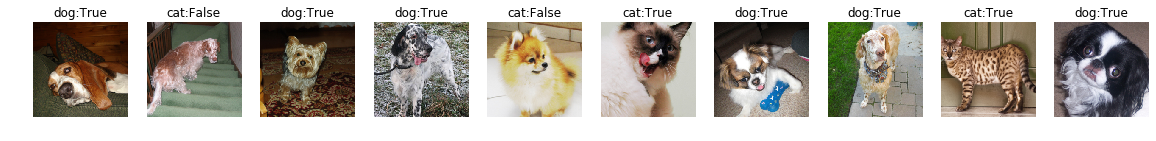

In [7]:
test_data_dir = 'data/test/species/'

to_pil = transforms.ToPILImage()
images, labels, classes = get_random_images(10)
fig=plt.figure(figsize=(20,20))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [8]:
test_data = torchvision.datasets.ImageFolder(test_data_dir,
                    transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data, 
                 batch_size=1)



    
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if use_gpu:
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        else:
            images, labels = Variable(inputs), Variable(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        label = labels[0]
        class_correct[label] += c.item()
        class_total[label] += 1

for i in range(2):
        print('Accuracy of %5s : %2d %%' % (
            
            classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of   cat : 91 %
Accuracy of   dog : 83 %
